<a href="https://colab.research.google.com/github/RomuloAlves2507/TrabalhoIA_unila_/blob/main/trabalhoIA_Unila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabalho de IA para Engenharia, tem como objetivo desenvolver e avaliar modelos de machine learning para diagnosticar a condição operacional de quatro componentes críticos (resfriador, válvula, bomba e acumulador) de um sistema hidráulico, utilizando dados brutos de múltiplos sensores.

Condition monitoring of hydraulic systems Data Set at ZeMA
     https://zenodo.org/records/1323611#.XfzEAEFCeUm

In [ ]:
#import das bibliotecas necessárias
import pandas as pd
import pyarrow
from google.colab import files
import io
import os
from IPython.display import clear_output
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
 #Criar arquivo parket a partir de 18 arquivos .txt (17 reais de sensores e 1 arquivo alvo)
def processar_arquivos_sensores(uploaded_files):
    print("Processando arquivos de SENSORES...")
    lista_de_dados_dos_arquivos = []
    numero_de_linhas_esperado = -1

    nomes_dos_arquivos = sorted(uploaded_files.keys())

    for filename in nomes_dos_arquivos:
        content = uploaded_files[filename].decode('utf-8')
        linhas = io.StringIO(content).readlines()

        if numero_de_linhas_esperado == -1:
            numero_de_linhas_esperado = len(linhas)
        elif len(linhas) != numero_de_linhas_esperado:
            print(f" ERRO: Arquivos de sensor com números de linhas diferentes!")
            print(f"Esperado: {numero_de_linhas_esperado}, Arquivo {filename} tem: {len(linhas)}")
            return None

    if numero_de_linhas_esperado == 0:
        print("Aviso: Os arquivos de sensores estão vazios.")
        return None

    print(f"Validação OK: Todos os {len(nomes_dos_arquivos)} arquivos de sensor têm {numero_de_linhas_esperado} linhas.")

    dados_combinados_finais = []

    for i in range(numero_de_linhas_esperado):
        linha_final_combinada = []
        for dados_arquivo_em_memoria in lista_de_dados_dos_arquivos:
            pass
        pass

    lista_de_dados_em_memoria = []
    for filename in nomes_dos_arquivos:
         content = uploaded_files[filename].decode('utf-8')
         linhas = io.StringIO(content).readlines()
         lista_de_dados_em_memoria.append(linhas)

    dados_combinados_finais = []
    for i in range(numero_de_linhas_esperado):
        linha_final_combinada = []
        for dados_arquivo in lista_de_dados_em_memoria:
            linha_atual = dados_arquivo[i].strip()
            valores_split = linha_atual.split()

            try:
                valores_float = []
                for val in valores_split:
                    val_corrigido = val.replace(',', '.')
                    valores_float.append(float(val_corrigido))
                linha_final_combinada.extend(valores_float)
            except ValueError as e:
                print(f" ERRO DE DADOS (Sensor) ")
                print(f"Linha: {i+1}, Valor: '{val}'")
                return None

        dados_combinados_finais.append(linha_final_combinada)

    print("Processamento de sensores concluído.")
    # Renomeia as colunas dos sensores para "f_0", "f_1", ... (feature_0, feature_1)
    df_sensores = pd.DataFrame(dados_combinados_finais)
    df_sensores.columns = [f'f_{i}' for i in range(len(df_sensores.columns))]

    return df_sensores, numero_de_linhas_esperado

def processar_arquivo_profile(uploaded_file, linhas_esperadas):
    print("Processando arquivo PROFILE...")

    if len(uploaded_file) != 1:
        print("ERRO: Por favor, selecione exatamente UM arquivo profile.txt")
        return None

    filename = list(uploaded_file.keys())[0]
    content = uploaded_file[filename].decode('utf-8')
    linhas = io.StringIO(content).readlines()

    if len(linhas) != linhas_esperadas:
        print(f"ERRO DE SINCRONIZAÇÃO")
        print(f"Os arquivos de sensor têm {linhas_esperadas} linhas, mas o profile.txt tem {len(linhas)} linhas.")
        return None

    print("Validação OK: O arquivo profile tem o mesmo número de linhas dos sensores.")

    dados_profile = []
    for i, linha_texto in enumerate(linhas):
        linha_atual = linha_texto.strip().split()

        # O profile.txt tem valores inteiros, não float
        try:
            # Converte para int
            valores_int = [int(float(v.replace(',', '.'))) for v in linha_atual]
            dados_profile.append(valores_int)
        except ValueError as e:
            print(f"ERRO DE DADOS (Profile)")
            print(f"Linha: {i+1}, Valor: '{linha_atual}'")
            return None

    # Nomes das colunas alvo
    colunas_alvo = ['resfriador', 'valvula', 'bomba', 'acumulador', 'stable_flag']

    df_profile = pd.DataFrame(dados_profile, columns=colunas_alvo[:len(dados_profile[0])])

    # Ajusta os nomes das colunas se o profile tiver menos de 5 colunas
    if len(df_profile.columns) < 5:
        df_profile.columns = colunas_alvo[:len(df_profile.columns)]

    print("Processamento do profile concluído.")
    return df_profile

def combinar_parquet():
    try:
        #Carregar Arquivos de Sensores (Features - X) ---
        print("ETAPA 1: SENSORES (FEATURES)")
        print("Por favor, selecione os 17 arquivos .txt dos SENSORES (PS1, TS1, CE, etc.)")
        uploaded_sensores = files.upload()
        if not uploaded_sensores:
            print("Nenhum arquivo de sensor selecionado. Operação cancelada.")
            return

        df_X, num_linhas = processar_arquivos_sensores(uploaded_sensores)
        if df_X is None:
            return

        #Carregar Arquivo de Alvo (Target - y)
        print("\n ETAPA 2: ALVO (TARGET)")
        print("Por favor, selecione o arquivo .txt de ALVO (profile.txt)")
        uploaded_profile = files.upload()
        if not uploaded_profile:
            print("Nenhum arquivo de alvo selecionado. Operação cancelada.")
            return

        df_y = processar_arquivo_profile(uploaded_profile, num_linhas)
        if df_y is None:
            return

        print("\n ETAPA 3: COMBINANDO DADOS")

        # Concatena os DataFrames lado a lado (axis=1)
        df_final_combinado = pd.concat([df_X, df_y], axis=1)

        print(f"Sucesso! Dados combinados.")
        print(f"Shape Final: {df_final_combinado.shape}")
        print("Primeiras 5 linhas e últimas 5 colunas (para conferir):")
        print(df_final_combinado.iloc[:5, -5:])

        #Salvar e Baixar o Parquet
        output_filename = 'dados_completos.parquet'
        print(f"\nSalvando arquivo Parquet como: {output_filename}")

        df_final_combinado.to_parquet(output_filename, engine='pyarrow', index=False)

        print(f"\n SUCESSO! :) ")
        print(f"Iniciando o download de '{output_filename}' para seu computador...")
        files.download(output_filename)

    except Exception as e:
        print(f"\n OCORREU UM ERRO ")
        print(f"Erro: {e}")


In [ ]:
# Configurações Globais
TARGET_COLUMNS = ['resfriador', 'valvula', 'bomba', 'acumulador']
FLAG_COLUMN = ['stable_flag']
X_global = None
y_global = None

def carregar_arquivo_parquet():
    print("Abrindo seletor de arquivos... Por favor, selecione seu arquivo .parquet")
    uploaded = files.upload()

    if not uploaded:
        print("Nenhum arquivo selecionado. Operação cancelada.")
        return None

    if len(uploaded) > 1:
        print("Por favor, selecione apenas UM arquivo. Operação cancelada.")
        return None

    filename = list(uploaded.keys())[0]
    print(f"Carregando '{filename}'...")

    try:
        df = pd.read_parquet(io.BytesIO(uploaded[filename]))
        print("Arquivo Parquet carregado com sucesso.")
        return df
    except Exception as e:
        print(f"Erro ao ler o arquivo Parquet: {e}")
        return None

def separar_features_e_alvos(df_completo):
    # Separa o DataFrame em X (features) e y (alvos)
    if df_completo is None:
        print("DataFrame de entrada está Vazio. Não é possível separar os dados.")
        return None, None

    print("Separando features (X) e alvos (y)...")

    try:
        y_targets = df_completo[TARGET_COLUMNS]
        colunas_para_remover_de_X = TARGET_COLUMNS + FLAG_COLUMN
        X_features = df_completo.drop(columns=colunas_para_remover_de_X)

        print(f" Shape das Features (X): {X_features.shape}")
        print(f" Shape dos Alvos (y):     {y_targets.shape}")

        return X_features, y_targets

    except KeyError as e:
        print(f" ERRO: Coluna não encontrada!")
        print(f"Verifique as constantes 'TARGET_COLUMNS' e 'FLAG_COLUMN'.")
        print(f"Colunas encontradas: {list(df_completo.columns)}")
        return None, None
    except Exception as e:
         print(f"Erro inesperado ao separar features e alvos: {e}")
         return None, None



In [ ]:
def randomForest(X, y):
    print("--- TREINANDO POR: RANDOM FOREST (BASELINE) ---")

    resultados = {}

    for target_name in y.columns:
        print(f"\nANALISANDO: {target_name.upper()}")

        # Prepara os dados
        y_target = y[target_name].astype(str)

        # Divisão Treino/Teste (70% treino, 30% teste)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_target, test_size=0.3, random_state=42, stratify=y_target
        )

        # Cria e Treina o Modelo (Usando 100 árvores)
        clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)

        # Previsão
        y_pred = clf.predict(X_test)

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        resultados[target_name] = acc

        print(f"Acurácia alcançada: {acc*100:.2f}%")

        # Plot Simples da Matriz de Confusão
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
        plt.title(f'Matriz de Confusão: {target_name}')
        plt.ylabel('Real')
        plt.xlabel('Predito')
        plt.show()

    print("\n" + "="*60)
    print("RESUMO FINAL DE ACURÁCIA:")
    for componente, acc in resultados.items():
        print(f"{componente.ljust(15)}: {acc*100:.2f}%")
    print("="*60)


In [ ]:
def arvore_decisao(X, y):
    print("\n" + "="*60)
    print("--- TREINAMENTO: ÁRVORE DE DECISÃO (Decision Tree) ---")
    print("="*60)

    for target_name in y.columns:
        print(f"\nANALISANDO: {target_name.upper()}")
        y_target = y[target_name].astype(str)

        # Divisão dos dados
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_target, test_size=0.3, random_state=42, stratify=y_target
        )

        # Cria e Treina o Modelo
        clf = DecisionTreeClassifier(random_state=42)
        clf.fit(X_train, y_train)

        # Previsão
        y_pred = clf.predict(X_test)

        # Cálculo da Acurácia
        acc = accuracy_score(y_test, y_pred)
        print(f"Acurácia: {acc*100:.2f}%")

        # --- GERAÇÃO DO GRÁFICO (Matriz de Confusão) ---
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(5, 4))
        # Usei 'Oranges' para diferenciar visualmente do Random Forest
        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
        plt.title(f'Matriz de Confusão: {target_name}')
        plt.ylabel('Real')
        plt.xlabel('Predito')
        plt.show() # No Colab, isso mostra o gráfico logo abaixo da célula

In [ ]:
def regressao_logistica(X, y):

    print("--- TREINAMENTO: REGRESSÃO LOGÍSTICA ---")

    for target_name in y.columns:
        print(f"\nANALISANDO: {target_name.upper()}")
        y_target = y[target_name].astype(str)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_target, test_size=0.3, random_state=42, stratify=y_target
        )

        # Cria Pipeline: Padronização -> Modelo Linear
        clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
        clf.fit(X_train, y_train)

        acc = accuracy_score(y_test, clf.predict(X_test))
        print(f"Acurácia: {acc*100:.2f}%")

In [ ]:
def gradient_boosting(X, y):

    print("--- TREINAMENTO: GRADIENT BOOSTING ---")

    for target_name in y.columns:
        print(f"\nANALISANDO: {target_name.upper()}")
        y_target = y[target_name].astype(str)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_target, test_size=0.3, random_state=42, stratify=y_target
        )

        clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)

        acc = accuracy_score(y_test, clf.predict(X_test))
        print(f"Acurácia: {acc*100:.2f}%")

In [ ]:
def lda(X, y):

    print("--- TREINAMENTO: LDA (Linear Discriminant Analysis) ---")

    for target_name in y.columns:
        print(f"\nANALISANDO: {target_name.upper()}")
        y_target = y[target_name].astype(str)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_target, test_size=0.3, random_state=42, stratify=y_target
        )

        clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
        clf.fit(X_train, y_train)

        acc = accuracy_score(y_test, clf.predict(X_test))
        print(f"Acurácia: {acc*100:.2f}%")

In [ ]:
def svm(X, y):

    print("--- TREINAMENTO: SVM (Support Vector Machine) ---")

    for target_name in y.columns:
        print(f"\nANALISANDO: {target_name.upper()}")
        y_target = y[target_name].astype(str)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_target, test_size=0.3, random_state=42, stratify=y_target
        )

        # SVM exige padronização para funcionar bem
        clf = make_pipeline(StandardScaler(), SVC(random_state=42))
        clf.fit(X_train, y_train)

        acc = accuracy_score(y_test, clf.predict(X_test))
        print(f"Acurácia: {acc*100:.2f}%")

Saving dados_completos.parquet to dados_completos (1).parquet
Carregando 'dados_completos (1).parquet'...
Arquivo Parquet carregado com sucesso.
Separando features (X) e alvos (y)...
 Shape das Features (X): (2205, 43680)
 Shape dos Alvos (y):     (2205, 4)

--- Dados prontos para o treinamento ---
--- Análise de Dados Hidráulicos ---
O que você gostaria de fazer?
  [1] Criar um novo arquivo 'dados_completos.parquet' a partir dos arquivos .txt
  [2] Carregar um arquivo .parquet existente para treinar
  [3] Iniciar Treinamento
  [Digite 'sair' para fechar]
Escolha uma opção: 3

Iniciando Treinamento...

--- TREINAMENTO: ÁRVORE DE DECISÃO (Decision Tree) ---

ANALISANDO: RESFRIADOR
Acurácia: 100.00%


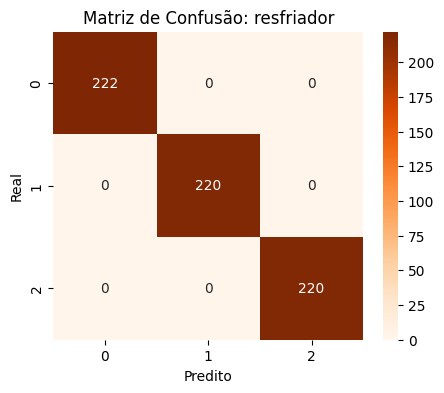


ANALISANDO: VALVULA
Acurácia: 100.00%


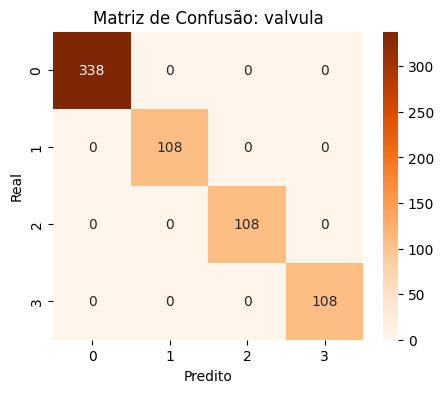


ANALISANDO: BOMBA
Acurácia: 98.04%


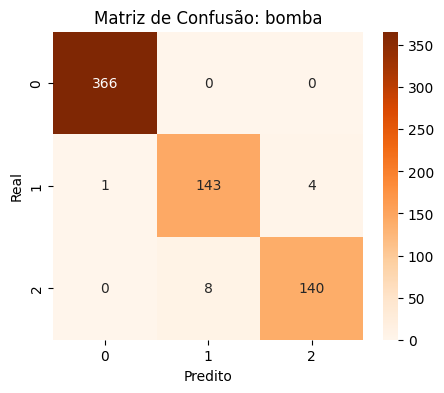


ANALISANDO: ACUMULADOR
Acurácia: 90.03%


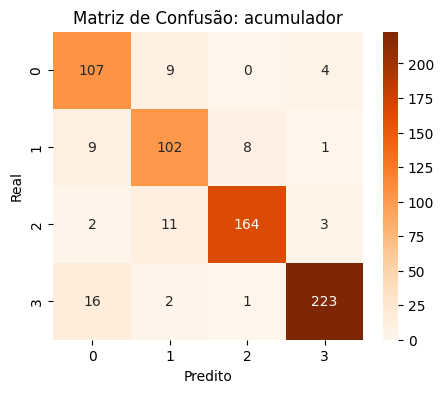

In [16]:
from numpy import gradient
if __name__ == "__main__":

    from IPython.display import clear_output

    while(True):

        clear_output(wait=True)

        print("--- Análise de Dados Hidráulicos ---")
        print("O que você gostaria de fazer?")
        print("  [1] Criar um novo arquivo 'dados_completos.parquet' a partir dos arquivos .txt")
        print("  [2] Carregar um arquivo .parquet existente para treinar")
        print("  [3] Iniciar Treinamento")
        print("  [Digite 'sair' para fechar]")

        escolha = input("Escolha uma opção: ")

        if escolha == '1':
            print("\nIniciando Módulo de Criação de Parquet...")
            combinar_parquet()
            input("\nProcesso concluído.")

        elif escolha == '2':
            print("\nIniciando Carregamento do Arquivo...")
            # 1. Carrega o arquivo Parquet
            df_principal = carregar_arquivo_parquet()

            if df_principal is not None:
                # 2. Separa os dados
                X_global, y_global = separar_features_e_alvos(df_principal)

                if X_global is not None and y_global is not None:
                    print("\n--- Dados prontos para o treinamento ---")
                    pass
                else:
                    print("Falha ao separar features e alvos.")
            else:
                print("Falha ao carregar o arquivo Parquet.")

            time.sleep(4)

        elif escolha == '3':

            if X_global is None or y_global is None:
                print("Nenhum conjunto de dados carregado.")

            else:

              print("\nIniciando Treinamento...")

              #randomForest(X_global, y_global)

              arvore_decisao(X_global, y_global)

              #regressao_logistica(X_global, y_global)

              #gradient_boosting(X_global, y_global)

              #lda(X_global, y_global)

              #svm(X_global, y_global)

              break

        elif escolha.lower() == 'sair':
            print("Encerrando o script.")
            break

        else:
            print("\nEscolha inválida. Tente novamente.")
            time.sleep(2)